In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

### Load data

In [2]:
def get_df():
    df = []
    for fname in glob.glob("csse_covid_19_data/csse_covid_19_daily_reports/*.csv"):
        report_date = fname.split("/")[-1].replace(".csv", "")
        _df = pd.read_csv(fname)
        _df["report_date"] = report_date
        _df.columns = [col.replace("/", "_").replace(" ","_") for col in _df.columns]
        df.append(_df)
    df = pd.concat(df)
    df["Last_Update"] = pd.to_datetime(df["Last_Update"])
    df["report_date"] = pd.to_datetime(df["report_date"])
    df["date"] = df["report_date"] # seems to make more sense than the "Last Update"
    df = df.sort_values(by="date")
    df = df.drop_duplicates()
    return df

In [3]:
def merge(df):
    # for merging several countries/regions
    df = df.groupby("date").sum()
    df = df.reset_index()
    return df

df = get_df()
df = df[df["Country_Region"] == "Germany"]
#df = merge(df[df["Country_Region"] == "US"])
#df = merge(df[df["Country_Region"].apply(lambda x : "Korea" in x)])
#df = merge(df[df["Country_Region"].apply(lambda x : "China" in x)])
#df = df[df["Country_Region"] == "Italy"]
#df = df[df["Country_Region"] == "Japan"]
#df = df[df["Country_Region"] == "Belgium"]
#df = df[df["Country_Region"] == "Iran"]
#df = df[df["Country_Region"] == "Spain"]
#df = df[df["Country_Region"] == "France"]
#df = df[df["Country_Region"] == "Sweden"]


for field in ["Confirmed", "Deaths", "Recovered"]:
    df[f"{field}_diff"] = df[field].diff()
    df[f"{field}_diff_diff"] = df[f"{field}_diff"].diff()

In [4]:
df.drop(
    columns=[
        col
        for col in [
            "Province_State",
            "report_date",
            "Latitude",
            "Longitude",
            "Lat",
            "Long_",
            "FIPS",
            "Admin2",
            "Combined_Key",
            "Active"
        ]
        if col in df
    ]
).tail()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,date,Confirmed_diff,Confirmed_diff_diff,Deaths_diff,Deaths_diff_diff,Recovered_diff,Recovered_diff_diff
3235,Germany,2020-03-22 23:45:00,24873.0,94.0,266.0,2020-03-22,2660.0,295.0,10.0,-7.0,33.0,-20.0
3310,Germany,2020-03-23 23:19:21,29056.0,123.0,453.0,2020-03-23,4183.0,1523.0,29.0,19.0,187.0,154.0
3310,Germany,2020-03-24 23:37:15,32986.0,157.0,3243.0,2020-03-24,3930.0,-253.0,34.0,5.0,2790.0,2603.0
3310,Germany,2020-03-25 23:33:04,37323.0,206.0,3547.0,2020-03-25,4337.0,407.0,49.0,15.0,304.0,-2486.0
3309,Germany,2020-03-26 23:48:18,43938.0,267.0,5673.0,2020-03-26,6615.0,2278.0,61.0,12.0,2126.0,1822.0


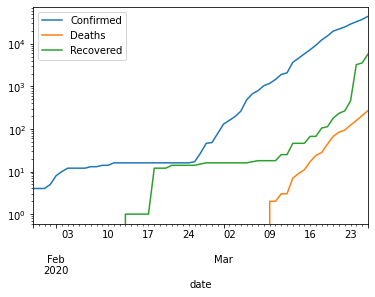

In [5]:
fig, ax = plt.subplots()
df.plot(x="date", y="Confirmed", ax=ax)
df.plot(x="date", y="Deaths", ax=ax)
df.plot(x="date", y="Recovered", ax=ax)
ax.set_yscale("log")

In [6]:
#df.plot.bar(x="date", y=["Confirmed_diff", "Deaths_diff", "Recovered_diff"], subplots=True)

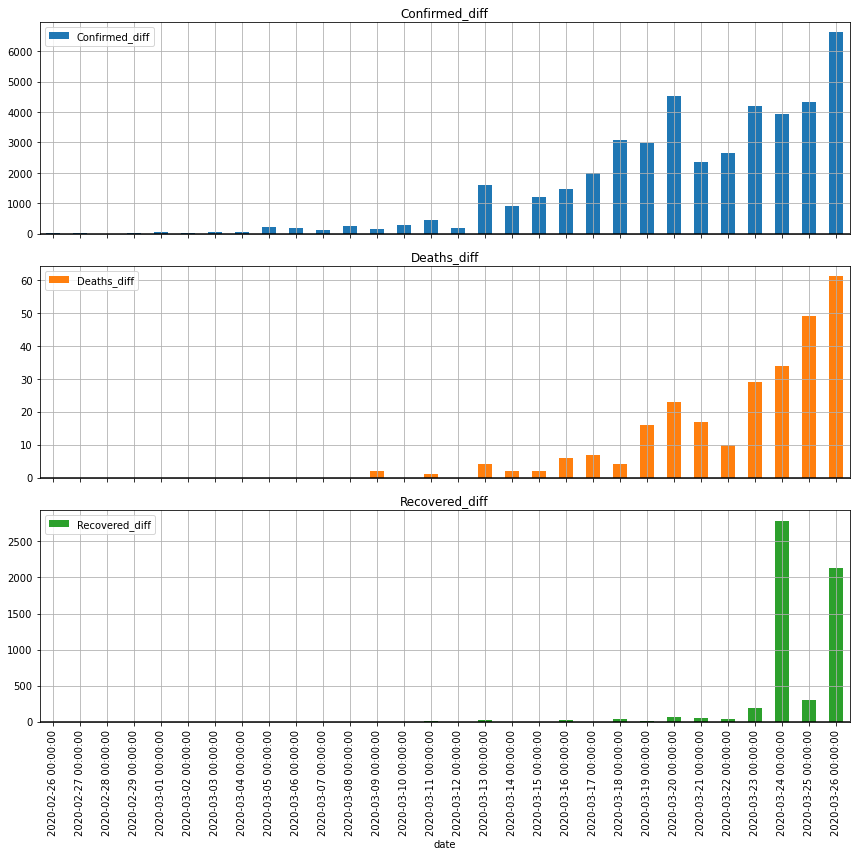

In [7]:
axs = df.iloc[-30:].plot.bar(
    x="date",
    #y=["Confirmed_diff_diff", "Deaths_diff_diff", "Recovered_diff_diff"],
    y=["Confirmed_diff", "Deaths_diff", "Recovered_diff"],
    subplots=True,
    figsize=(12, 12)
)
for ax in axs:
    ax.axhline(0, color="black")
    #ax.set_yscale("symlog")
    ax.grid()
fig = axs[0].get_figure()
fig.tight_layout()
#fig.savefig("diff_diff.pdf")

### Fit exponential

In [8]:
def func(x, a, b, c):
    return a * np.exp(b * (x - c))

In [9]:
def get_xy(df, field="Confirmed"):
    # DataFrame contains cumulative cases (called 'int' here)
    # np.diff gives new confirmed cases per day
    x_int = df["date"].astype("int").values
    x_int = (x_int - x_int[0]) / 1e9 / 3600 / 24
    x = x_int[1:]
    y = np.diff(df[field]) / np.diff(x_int)
    y = np.nan_to_num(y)
    y_int = df[field].values
    y_int = np.nan_to_num(y_int)
    
    return x, y, x_int, y_int

Exponential fit for new and cumulative cases per day:

In [10]:
fields = ["Confirmed", "Deaths"]

In [11]:
fit_results_diff = {}
fit_results_int = {}
fit_data = {}
for field in fields:
    fit_data[field] = get_xy(df, field=field)
    x, y, x_int, y_int = fit_data[field]
    est_b_y = np.log(2) / np.count_nonzero(y > y[-1] * 0.5)
    est_b_y_int = np.log(2) / np.count_nonzero(y_int > y_int[-1] * 0.5)
    est_c_y = x[y>0][0]
    est_c_y_int = x_int[y_int>0][0]
    fit_results_diff[field] = scipy.optimize.curve_fit(func, x, y, p0=(1, est_b_y, est_c_y))
    fit_results_int[field] = scipy.optimize.curve_fit(func, x_int, y_int, p0=(1, est_b_y_int, est_c_y_int))

<ipython-input-8-54abd0354d15>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * (x - c))


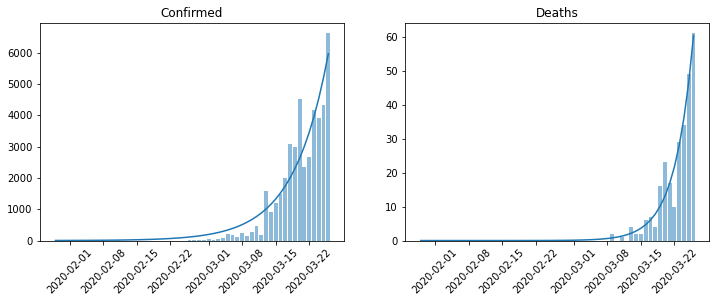

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for ax, field in zip(axs, fields):
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]
    ax.bar(df["date"][1:], y, alpha=0.5)
    ax.plot(df["date"][1:], func(x, *popt))
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(field)

Plot both new and cumulative

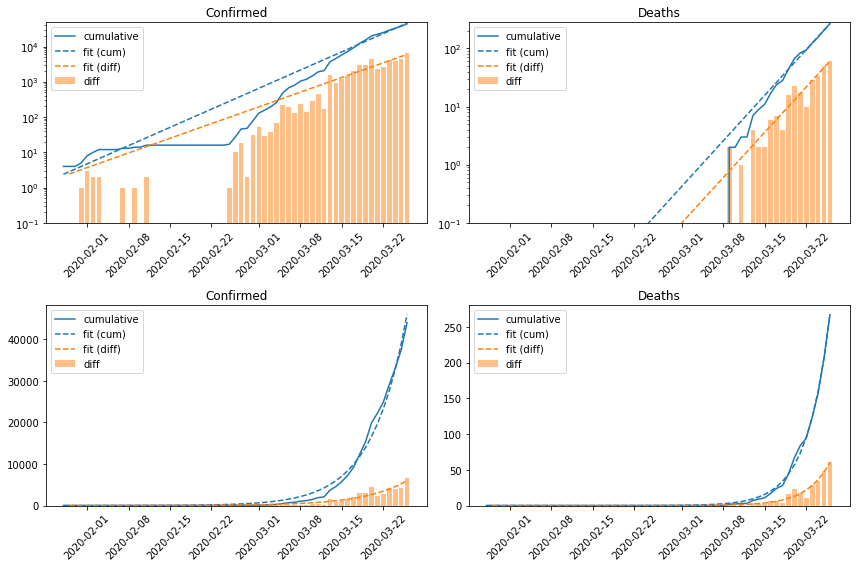

In [13]:
fig, axs = plt.subplots(ncols=len(fields), nrows=2, figsize=(12, 8))

for row, scale in zip(range(2), ["log", "linear"]):
    for col, field in enumerate(fields):
        ax = axs[row][col]

        x, y, x_int, y_int = fit_data[field]
        popt, pcov = fit_results_diff[field]
        popt_int, pcov_int = fit_results_int[field]

        ax.plot(df["date"], y_int, label="cumulative", color="C0")
        ax.plot(df["date"], func(x_int, *popt_int), "--", label="fit (cum)", color="C0")

        ax.bar(df["date"][1:], y, label="diff", color="C1", alpha=0.5)
        ax.plot(df["date"][1:], func(x, *popt), "--", label="fit (diff)", color="C1")

        ax.xaxis.set_tick_params(rotation=45)
        ax.legend()

        #ax.set_yscale("log")
        if scale == "log":
            ax.set_ylim(bottom=1e-1)
        #ax.set_ylim(auto=True)
        #ax.set_yscale("linear")
        ax.set_yscale(scale)

        ax.set_title(field)
fig.tight_layout()

Development of relative increase per day

<ipython-input-14-f40e7cdd63bf>:16: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(df["date"][1:], y / y_int[:-1], ".", color="C0")
<ipython-input-14-f40e7cdd63bf>:16: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(df["date"][1:], y / y_int[:-1], ".", color="C0")
<ipython-input-14-f40e7cdd63bf>:19: RuntimeWarning: divide by zero encountered in true_divide
  moving_average(y / y_int[:-1], n=window),
<ipython-input-14-f40e7cdd63bf>:19: RuntimeWarning: invalid value encountered in true_divide
  moving_average(y / y_int[:-1], n=window),


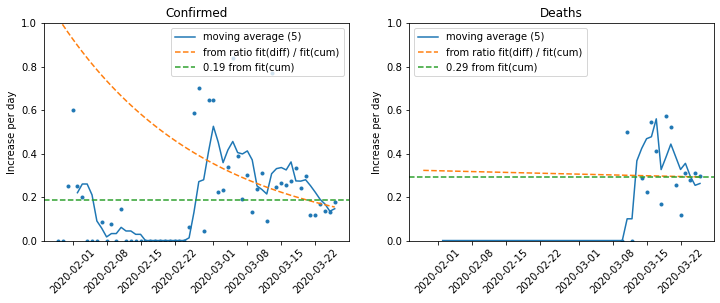

In [14]:
def moving_average(a, n=3) :
    ret = np.cumsum(np.nan_to_num(a, posinf=0, neginf=0), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
window = 5

for ax, field in zip(axs, fields):

    popt_int, pcov_int = fit_results_int[field]
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]

    inc_from_param = np.exp(popt_int[1]) - 1
    ax.plot(df["date"][1:], y / y_int[:-1], ".", color="C0")
    ax.plot(
        df["date"][window:],
        moving_average(y / y_int[:-1], n=window),
        color="C0",
        label=f"moving average ({window})"
    )
    ax.plot(
        df["date"][1:],
        func(x, *popt) / func(x_int, *popt_int)[:-1],
        color="C1",
        linestyle="--",
        label="from ratio fit(diff) / fit(cum)"
    )
    ax.axhline(inc_from_param, linestyle="--", color="C2", label=f"{inc_from_param:.2f} from fit(cum)")
    ax.set_ylabel("Increase per day")
    ax.xaxis.set_tick_params(rotation=45)
    ax.legend()
    ax.set_title(field)
    ax.set_ylim(0, 1)

### Extrapolation of cumulative cases

Extrapolated until 2020-03-30 00:00:00
Confirmed: 90654.15030567063
Deaths: 749.2719822089545


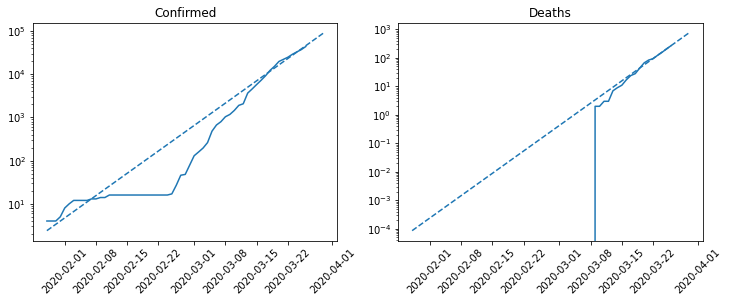

In [15]:
dates_extrap = pd.date_range(start=df.date.iloc[0], end="2020-03-30", freq="d")
days = np.arange(len(dates_extrap))

fig, axs = plt.subplots(ncols=len(fields), figsize=(12, 4))

print(f"Extrapolated until {dates_extrap[-1]}")

for ax, field in zip(axs, fields):
    popt_int, pcov_int = fit_results_int[field]
    x, y, x_int, y_int = fit_data[field]
    pred = func(days, *popt_int)
    ax.plot(df["date"], y_int, label="confirmed", color="C0")
    ax.plot(dates_extrap, pred, "--", color="C0")
    ax.set_yscale("log")
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(field)
    print(f"{field}: {pred[-1]}") # predicted by end of range

### Fitted Parameters and doubling time

In [16]:
fit_results_int

{'Confirmed': (array([ 1.3684782 ,  0.17004888, -3.28186111]),
  array([[2.40259228e+10, 1.65781837e+02, 1.03335875e+11],
         [1.65781845e+02, 1.70669240e-05, 7.13035849e+02],
         [1.03335875e+11, 7.13035815e+02, 4.44449236e+11]])),
 'Deaths': (array([ 1.99379326,  0.2576968 , 38.99209633]),
  array([[ 1.43433730e+12, -8.28689316e+01,  2.79165780e+12],
         [-8.28684515e+01,  9.71691223e-06, -1.61286618e+02],
         [ 2.79165780e+12, -1.61287557e+02,  5.43341744e+12]]))}

In [17]:
fit_results_diff

{'Confirmed': (array([2.98710979, 0.13679946, 2.44750358]),
  array([[1.19626187e+12, 3.32354679e+03, 2.93044273e+12],
         [3.32354661e+03, 9.96818204e-05, 8.14161570e+03],
         [2.93044273e+12, 8.14161617e+03, 7.17860764e+12]])),
 'Deaths': (array([ 1.00441909,  0.25596995, 41.99486114]),
  array([[ 5.84122743e+12, -4.11541213e+03,  2.26970782e+13],
         [-4.11541322e+03,  1.70319944e-04, -1.59911254e+04],
         [ 2.26970782e+13, -1.59911211e+04,  8.81933400e+13]]))}

In [18]:
np.log(2) / fit_results_int["Confirmed"][0][1]

4.076164223459029

In [19]:
np.log(2) / fit_results_int["Deaths"][0][1]

2.68977803029412

### Death rate

In [20]:
df["death_rate"] = df["Deaths"] / df["Confirmed"]

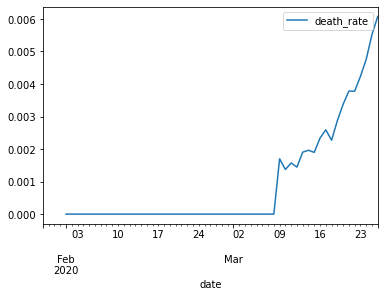

In [21]:
df.plot(x="date", y="death_rate")